In [1]:
import os
import gc
import seaborn as sns
import pandas as pd
import numpy as np
import transformers
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, LSTM, Dropout, Activation, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Loading training/validation/test data.

In [2]:
kaggle = '/kaggle/input/xlmroberta-tokenized/'
kaggle1 = '/kaggle/input/undersampled-xlm-roberta-tokenizer/'
ensembled = '/kaggle/input/blending-vibes/'

x_train = np.load(f'{kaggle}x_train.npy/x_train.npy')
y_train = np.load(f'{kaggle}y_train.npy')
y_train = y_train.astype(int)

x_valid = np.load(f'{kaggle1}x_valid.npy')
y_valid = np.load(f'{kaggle}y_valid.npy')

x_test1 = np.load(f'{kaggle}x_test1.npy')
x_test2 = np.load(f'{kaggle}x_test2.npy')
x_test3 = np.load(f'{kaggle}x_test3.npy')

y_test1 = pd.read_csv(f'{ensembled}submission_ensemble.csv')
y_test1 = y_test1.toxic

In [3]:
y_test1 = np.where(y_test1<0.5, 0,1)
y_test1 = y_test1.astype(int)

In [4]:
training = np.concatenate([x_train, x_test1])
labels = np.concatenate([y_train, y_test1])

### TPU Configuration

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [6]:
# Global Variables
BATCHSIZE = 128
EPOCHS = 4
PRE_TRAINED = '/kaggle/input/finetune-xlm-roberta-on-jigsaw-test-data-with-mlm'
AUTO = tf.data.experimental.AUTOTUNE
NUMCORES = strategy.num_replicas_in_sync

Helper function to build model.

In [7]:
def build(transformer, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_word_ids")
    cls_token = transformer(input_ids)[0][:,0,:]
    out = tf.reshape(cls_token, [-1, 1, cls_token.shape[1]])
    out = Dropout(0.25)(out)
    gru1 = Bidirectional(GRU(1024, activation='relu'))(out)
    rs = tf.reshape(gru1, [-1, 1, 2048])
    rs = Dropout(0.25)(rs)
    out = Bidirectional(GRU(2048, activation='relu'))(rs)
    out = Dense(1, activation='sigmoid')(out)
    model = Model(inputs=input_ids, outputs=out)
    model.compile(tfa.optimizers.AdamW(weight_decay=1e-9, learning_rate=1e-5), 
                  loss='binary_crossentropy', metrics=['accuracy', AUC()])
    return model

Create TF dataset objects.

In [8]:
train_dataset = (
    tf.data.Dataset
        .from_tensor_slices((training, labels))
        .repeat()
        .shuffle(x_train.shape[0])
        .batch(BATCHSIZE)
        .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
        .from_tensor_slices((x_valid, y_valid))
        .batch(BATCHSIZE)
        .cache()
        .prefetch(AUTO)
)

test1 = (
    tf.data.Dataset
        .from_tensor_slices(x_test1)
        .batch(BATCHSIZE)
)

test2 = (
    tf.data.Dataset
        .from_tensor_slices(x_test2)
        .batch(BATCHSIZE)
)

test3 = (
    tf.data.Dataset
        .from_tensor_slices(x_test3)
        .batch(BATCHSIZE)
)

# Training

In [9]:
%%time
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained(PRE_TRAINED)
    model = build(transformer_layer, maxlen=192)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 192, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(None, 1, 1024)]         0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 1, 1024)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 2048)              12595200  
_________________________________________________________________
tf_op_layer_Reshape_1 (Tenso [(None, 1, 2048)]         0     

In [10]:
class EarlyTesting(tf.keras.callbacks.Callback):
    results = []
    def __init__(self, x_test: list):
        super(EarlyTesting, self).__init__()
        self.test = x_test
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 3:
            for test in self.test:
                p_test = self.model.predict(test)[0:len(x_test1)].flatten()
                self.results.append(p_test)

Callbacks to predict on test set after every epoch

In [11]:
checkpoints = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', verbose=1,
                                                 save_best_only=True, save_weights_only=True,
                                                 mode='min', save_freq='epoch') 
et = EarlyTesting([x_test1])
training_history = model.fit(train_dataset, 
                    steps_per_epoch=680, 
                    validation_data=valid_dataset,
                    epochs=10,
                    callbacks=[checkpoints, et])
print(EarlyTesting.results)

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


680/680 [==============================] - ETA: 0s - loss: 0.3024 - auc: 0.9433 - accuracy: 0.8691
Epoch 00001: val_loss improved from inf to 0.34866, saving model to model.h5
680/680 [==============================] - 342s 503ms/step - loss: 0.3024 - auc: 0.9433 - accuracy: 0.8691 - val_loss: 0.3487 - val_auc: 0.9278 - val_accuracy: 0.8605
Epoch 2/10
680/680 [==============================] - ETA: 0s - loss: 0.2254 - auc: 0.9675 - accuracy: 0.9090
Epoch 00002: val_loss improved from 0.34866 to 0.26617, saving model to model.h5
680/680 [==============================] - 306s 450ms/step - loss: 0.2254 - auc: 0.9675 - accuracy: 0.9090 - val_loss: 0.2662 - val_auc: 0.9094 - val_accuracy: 0.8983
Epoch 3/10
680/680 [==============================] - ETA: 0s - loss: 0.2298 - auc: 0.9655 - accuracy: 0.9064
Epoch 00003: val_loss did not improve from 0.26617
680/680 [==============================] - 297s 437ms/step - loss: 0.2298 - auc: 0.9655 - accuracy: 0.9064 - val_loss: 0.2704 - val_auc: 0

# Train on Validation Data

In [12]:
CLASS_WEIGHTS = {0:1, 1:7}
model.load_weights('model.h5')

training_history = model.fit(valid_dataset.repeat(), 
                    steps_per_epoch=len(x_valid)//BATCHSIZE,
                    validation_data=train_dataset,
                    epochs=2,
                    validation_steps=500,
                    class_weight=CLASS_WEIGHTS)

Epoch 1/2
62/62 [==============================] - 89s 1s/step - loss: 0.6156 - auc: 0.9301 - accuracy: 0.8100 - val_loss: 0.2596 - val_auc: 0.9630 - val_accuracy: 0.9072
Epoch 2/2
62/62 [==============================] - 89s 1s/step - loss: 0.4153 - auc: 0.9672 - accuracy: 0.8690 - val_loss: 0.2941 - val_auc: 0.9556 - val_accuracy: 0.9061


# Plotting Training History

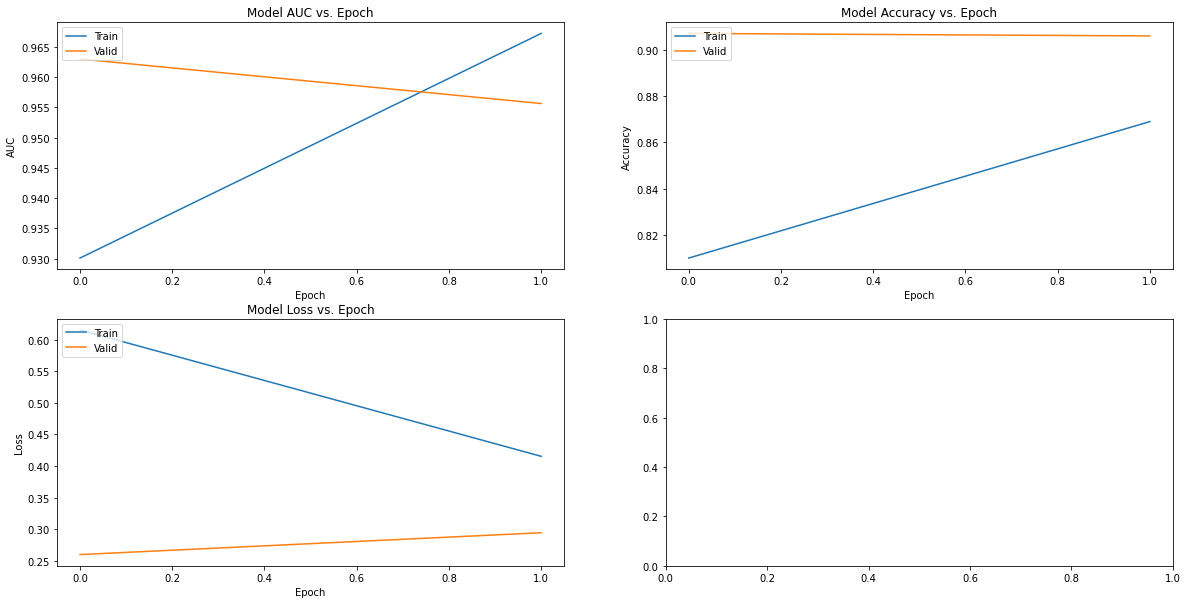

In [13]:
import matplotlib.pyplot as plt


f, axarr = plt.subplots(2, 2, figsize=(20, 10))
auc = axarr[0,0]
acc = axarr[0,1]
loss = axarr[1,0]

auc.plot(training_history.history['auc'])
auc.plot(training_history.history['val_auc'])
auc.set_title('Model AUC vs. Epoch')
auc.set_ylabel('AUC')
auc.set_xlabel('Epoch')
auc.legend(['Train', 'Valid'], loc='upper left')

acc.plot(training_history.history['accuracy'])
acc.plot(training_history.history['val_accuracy'])
acc.set_title('Model Accuracy vs. Epoch')
acc.set_ylabel('Accuracy')
acc.set_xlabel('Epoch')
acc.legend(['Train', 'Valid'], loc='upper left')

loss.plot(training_history.history['loss'])
loss.plot(training_history.history['val_loss'])
loss.set_title('Model Loss vs. Epoch')
loss.set_ylabel('Loss')
loss.set_xlabel('Epoch')
loss.legend(['Train', 'Valid'], loc='upper left')

# Inference


In [14]:
np.save('individual_predictions', EarlyTesting.results)

In [15]:
model.load_weights('model.h5')
valid = model.predict(valid_dataset, verbose=1)[0:len(x_valid)].flatten()
ids = list(range(len(valid)))
valid_submission = pd.DataFrame({'id': ids, 'toxic': valid}, columns=['id', 'toxic'])
valid_submission.to_csv('valid_submission.csv')

63/63 [==============================] - 19s 307ms/step


In [16]:
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

ptest1 = model.predict(test1, verbose=1)[0:len(sub['toxic'])].flatten()
EarlyTesting.results.append(ptest1)
alltests = np.array(EarlyTesting.results)
sub.toxic = alltests.mean(axis=0)
sub.to_csv('submission.csv', index=False)

499/499 [==============================] - 68s 136ms/step
